In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import pdist, cdist

import torch
from torch.nn.functional import pad as pad

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error as mae, 

import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import time

import warnings
warnings.filterwarnings('ignore')

In [3]:
data_folder = '/content/drive/My Drive/Colab Notebooks/'

structures = pd.read_csv(data_folder + 'structures.csv')
train = pd.read_csv(data_folder + 'train.csv')
test = pd.read_csv(data_folder + 'test.csv')
scalar_coupling_contributions = pd.read_csv(data_folder + 'scalar_coupling_contributions.csv')
structures.head()

,molecule_name,atom_index,atom,x,y,z
0,dsgdb9nsd_000001,0,C,-0.012698,1.085804,0.008001
1,dsgdb9nsd_000001,1,H,0.002150,-0.006031,0.001976
2,dsgdb9nsd_000001,2,H,1.011731,1.463751,0.000277
3,dsgdb9nsd_000001,3,H,-0.540815,1.447527,-0.876644
4,dsgdb9nsd_000001,4,H,-0.523814,1.437933,0.906397


In [4]:
train.head()

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant
0,0,dsgdb9nsd_000001,1,0,1JHC,84.8076
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.2570
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.2548
3,3,dsgdb9nsd_000001,1,4,2JHH,-11.2543
4,4,dsgdb9nsd_000001,2,0,1JHC,84.8074


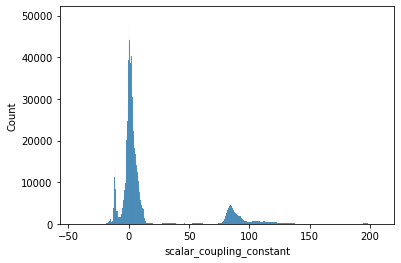

In [5]:
sns.histplot(train.scalar_coupling_constant)

1JHC: 84720 molecules and 709133 interactions
2JHH: 81335 molecules and 377988 interactions
1JHN: 28642 molecules and 43680 interactions
2JHN: 40322 molecules and 119059 interactions
2JHC: 84816 molecules and 1140867 interactions
3JHH: 76940 molecules and 590529 interactions
3JHC: 84802 molecules and 1511207 interactions
3JHN: 45671 molecules and 166613 interactions


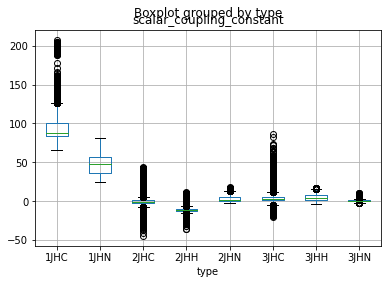

In [ ]:
interaction_types = train.type.unique()

for i in range(len(interaction_types)):
  train_type = train[train.type == interaction_types[i]]
  print(f'{interaction_types[i]}: {train_type.molecule_name.nunique()} molecules and {train_type.molecule_name.count()} interactions')

train.boxplot(column='scalar_coupling_constant', by='type')

In [ ]:
scalar_coupling_contributions.head()

,molecule_name,atom_index_0,atom_index_1,type,fc,sd,pso,dso
0,dsgdb9nsd_000001,1,0,1JHC,83.0224,0.254579,1.25862,0.272010
1,dsgdb9nsd_000001,1,2,2JHH,-11.0347,0.352978,2.85839,-3.433600
2,dsgdb9nsd_000001,1,3,2JHH,-11.0325,0.352944,2.85852,-3.433870
3,dsgdb9nsd_000001,1,4,2JHH,-11.0319,0.352934,2.85855,-3.433930
4,dsgdb9nsd_000001,2,0,1JHC,83.0222,0.254585,1.25861,0.272013


In [ ]:
# array of coordinates
xyz = structures[['x','y','z']].values
xyz

array([[-1.26981359e-02,  1.08580416e+00,  8.00099580e-03],
       [ 2.15041600e-03, -6.03131760e-03,  1.97612040e-03],
       [ 1.01173084e+00,  1.46375116e+00,  2.76574800e-04],
       ...,
       [ 2.51585406e+00, -1.15178377e+00,  5.27369256e-01],
       [ 1.36988019e-02,  1.19943057e+00, -1.68019230e+00],
       [ 1.26074533e+00, -1.24675365e+00, -1.90676716e+00]])

In [ ]:
# molecule size
ss = structures.groupby('molecule_name').size()
ss = ss.cumsum()
ss.head()

molecule_name
dsgdb9nsd_000001     5
dsgdb9nsd_000002     9
dsgdb9nsd_000003    12
dsgdb9nsd_000004    16
dsgdb9nsd_000005    19
dtype: int64

In [ ]:
# start index of molecule
ssx = np.zeros(len(ss) + 1, 'int')
ssx[1:] = ss
ssx

array([      0,       5,       9, ..., 2358841, 2358859, 2358875])

In [ ]:
# dict {molecule name: molecule id
name_idx_dict = {k: v for k, v in zip(ss.reset_index().molecule_name, range(len(ss)))}
name_idx_dict['dsgdb9nsd_000002']

1

In [ ]:
# array of atom charges
labelled_atoms = structures.atom.copy()
labelled_atoms = labelled_atoms.replace({'H': 1, 'C': 6, 'N': 7, 'O': 8, 'F': 9}).to_numpy()
labelled_atoms

array([6, 1, 1, ..., 1, 1, 1])

In [ ]:
max_molecule_size = train.atom_index_0.max() + 1
num_molecules = structures.molecule_name.nunique()

In [ ]:
def bond_dist(mol_id):
  """Returns matrix of distances between atoms in molecule"""
  molecule = xyz[ssx[mol_id]:ssx[mol_id+1]]

  return cdist(molecule, molecule)

In [ ]:
def all_bonds():
  all_bonds = list()
  for i in range(num_molecules):
    all_bonds.append(bond_dist(i))
  return all_bonds

In [ ]:
total_bonds = all_bonds()

In [ ]:
total_bonds[0]

array([[0.        , 1.09195306, 1.09195162, 1.09194638, 1.09194754],
       [1.09195306, 0.        , 1.78311976, 1.7831475 , 1.78315669],
       [1.09195162, 1.78311976, 0.        , 1.78315766, 1.78314839],
       [1.09194638, 1.7831475 , 1.78315766, 0.        , 1.78314787],
       [1.09194754, 1.78315669, 1.78314839, 1.78314787, 0.        ]])

In [ ]:
train_interaction = train.copy()
test_interaction = test.copy()

train_interaction.type = train_interaction.type.apply(lambda x: x[0]).astype(float)
test_interaction.type = test_interaction.type.apply(lambda x: x[0]).astype(float)

train_interaction[['1J', '2J', '3J']] = pd.get_dummies(train_interaction.type)
test_interaction[['1J', '2J', '3J']] = pd.get_dummies(test_interaction.type)

train_interaction.head()

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,1J,2J,3J
0,0,dsgdb9nsd_000001,1,0,1.0,84.8076,1,0,0
1,1,dsgdb9nsd_000001,1,2,2.0,-11.2570,0,1,0
2,2,dsgdb9nsd_000001,1,3,2.0,-11.2548,0,1,0
3,3,dsgdb9nsd_000001,1,4,2.0,-11.2543,0,1,0
4,4,dsgdb9nsd_000001,2,0,1.0,84.8074,1,0,0


In [ ]:
train_interaction = train_interaction[['molecule_name', 'atom_index_0', 'atom_index_1', '1J', '2J', '3J']].values
test_interaction = test_interaction[['molecule_name', 'atom_index_0', 'atom_index_1', '1J', '2J', '3J']].values
train_interaction[:11]

array([['dsgdb9nsd_000001', 1, 0, 1, 0, 0],
       ['dsgdb9nsd_000001', 1, 2, 0, 1, 0],
       ['dsgdb9nsd_000001', 1, 3, 0, 1, 0],
       ['dsgdb9nsd_000001', 1, 4, 0, 1, 0],
       ['dsgdb9nsd_000001', 2, 0, 1, 0, 0],
       ['dsgdb9nsd_000001', 2, 3, 0, 1, 0],
       ['dsgdb9nsd_000001', 2, 4, 0, 1, 0],
       ['dsgdb9nsd_000001', 3, 0, 1, 0, 0],
       ['dsgdb9nsd_000001', 3, 4, 0, 1, 0],
       ['dsgdb9nsd_000001', 4, 0, 1, 0, 0],
       ['dsgdb9nsd_000002', 1, 0, 1, 0, 0]], dtype=object)

In [ ]:
def angle(atom1, atom2, atom3):
  """angle atom1-atom2-atom3"""
  v1 = atom2 - atom1
  v2 = atom2 - atom3
  cos_theta = np.dot(v1, v2) / ((np.linalg.norm(v1) * np.linalg.norm(v2)) + 1e-10)
  return np.arccos(cos_theta)

In [ ]:
def molecule(mol_id):
  """Returns atom coordinates in molecule"""
  start_idx = ssx[mol_id]
  end_idx = ssx[mol_id+1]
  
  molecule = xyz[start_idx:end_idx]
  mean_axes = np.mean(molecule, axis=0)

  return molecule - mean_axes

In [ ]:
def add_zeros(atom_dist_matr: list, n_closest):
  """If amount of atoms in molecule is smaller then n_closest+1 appends "atom" with charge -1 and distance 100
  to list of atom neighbours and distances.
  If amount of atom neighbours is larger than n_closest removes atoms with longer distance"""
  while len(atom_dist_matr) < 2 + n_closest * 2:
    atom_dist_matr.append(-1)
    atom_dist_matr.append(100.)
  atom_dist_matr = atom_dist_matr[:2 * n_closest + 2]

  return atom_dist_matr

In [ ]:
def closest_distances(atoms, bonds, id_0, id_1, n_closest=2):
  """returns array of atoms surrounding atom with id=id_0 and distances from atom_0 to that atom
  first is atom with id_1 and then from closest neighbours to farthest"""
  dist_atom_0 = bonds[id_0].copy() # distances from first interacting atom (id_0) to other atoms
  interaction_distance = dist_atom_0[id_1] # distance between atoms in involved in interaction
  
  sorted_indexes_0 = np.argsort(dist_atom_0)

  res = [atoms[id_1], interaction_distance]

  for i in range(1, len(atoms)):
    idx = sorted_indexes_0[i]

    if idx != id_1:
      res.append(int(atoms[idx]))
      res.append(float(dist_atom_0[idx]))

  res = add_zeros(res, n_closest)
  
  return res

In [ ]:
def angles(atoms, coords, bonds, id_0):
  """Returns angle between atom with id=id_0 if atom is not hydrogen or
  angle between heavy atom closest to atom id_0
  and its closest neighbours"""
  dist_atom_0 = bonds[id_0]

  sorted_indexes_0 = np.argsort(dist_atom_0)

  # if atom is hydrogen we should find closest heavy atom to calculate bond angle
  while atoms[id_0] == 1:
    id_0 = sorted_indexes_0[1]
    dist_atom_0 = bonds[id_0]
    sorted_indexes_0 = np.argsort(dist_atom_0)

  return angle(coords[sorted_indexes_0[1]], coords[id_0], coords[sorted_indexes_0[2]])

In [ ]:
def scc_params(row):
  """returns parameters used for ML"""
  mol_id = name_idx_dict[row[0]]
  atom_0 = row[1]
  atom_1 = row[2]
  scc_type = row[3:6]

  atoms = labelled_atoms[ssx[mol_id]:ssx[mol_id+1]]
  coords = molecule(mol_id)
  bonds = total_bonds[mol_id].copy()


  atom_0_neighbours = closest_distances(atoms, bonds, atom_0, atom_1, n_closest=2)
  atom_1_neighbours = closest_distances(atoms, bonds, atom_1, atom_0, n_closest=2)

  atom_int = np.r_[scc_type, atom_0_neighbours, atom_1_neighbours[2:],
                   angles(atoms, coords, bonds, atom_0), angles(atoms, coords, bonds, atom_1)]

  return atom_int

In [ ]:
def scc_id_atoms(interaction):
  a = time.time()
  res = []
  for i in range(len(interaction)):
    res += [scc_params(interaction[i])]
    if i % 500000 == 0:
      print(i, round((time.time()-a)/60, 2), 'min')
  
  return res

In [ ]:
start = time.time()
X_all = scc_id_atoms(train_interaction)
end = time.time()
print(round((end-start)/60, 2), 'min')

0 0.0 min
500000 1.82 min
1000000 3.64 min
1500000 5.48 min
2000000 7.34 min
2500000 9.2 min
3000000 11.08 min
3500000 12.97 min
4000000 14.87 min
4500000 16.78 min
17.35 min


In [ ]:
X_all = np.array(X_all).astype('float')
np.save('/content/drive/My Drive/Colab Notebooks/X_all_new.npy', X_all)

In [ ]:
start = time.time()
X_test = scc_id_atoms(test_interaction)
end = time.time()
print(round((end-start)/60, 2), 'min')

0 0.0 min
500000 1.85 min
1000000 3.69 min
1500000 5.57 min
2000000 7.47 min
2500000 9.37 min
9.39 min


In [ ]:
X_test = np.array(X_test).astype('float')
np.save('/content/drive/My Drive/Colab Notebooks/X_test_new.npy', X_test)

In [ ]:
X_all = torch.from_numpy(X_all)
X_test = torch.from_numpy(X_test)

In [ ]:
del train_interaction
del test_interaction

In [6]:
# X_all = torch.from_numpy(np.load('/content/drive/My Drive/Colab Notebooks/X_all_new.npy'))
# X_test = torch.from_numpy(np.load('/content/drive/My Drive/Colab Notebooks/X_test_new.npy'))

In [7]:
tr_scc_contrib = pd.merge(train, scalar_coupling_contributions, on=['molecule_name',	'atom_index_0',	'atom_index_1',	'type'], how='left')

y = torch.Tensor(tr_scc_contrib[['fc', 'sd', 'pso', 'dso']].values)
del tr_scc_contrib, scalar_coupling_contributions

In [ ]:
# DecisionTreeRegressor

In [ ]:
x_tr, x_test, y_tr, y_test = train_test_split(X_all, y, test_size=0.05)
x_tr, x_val, y_tr, y_val = train_test_split(X_all, y, test_size=0.2)

In [ ]:
depth_list = list(range(20, 31))

tree_list = []
train_loss_list = []
val_loss_list = []

for depth in depth_list:
  start_time = time.time()
  regr = DecisionTreeRegressor(max_depth=depth)

  regr.fit(x_tr, y_tr)
  train_loss_list.append(regr.score(x_tr, y_tr))
  val_loss_list.append(regr.score(x_val, y_val))

  print(f'{round(time.time() - start_time, 1)} s')
  print(f'depth= {depth} train score: {train_loss_list[-1]}, val score: {val_loss_list[-1]}')

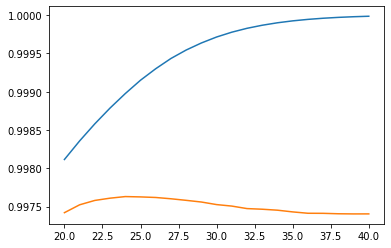

In [ ]:
plt.plot(depth_list, train_loss_list)
plt.plot(depth_list, val_loss_list)

In [ ]:
# choosing the best regressor based on val loss (24)
best_idx = val_loss_list.index(max(val_loss_list))

In [ ]:
# fitting the best regressor with a full train dataset
regr = DecisionTreeRegressor(max_depth=depth_list[best_idx])
regr.fit(X_all, y)
regr.score(X_all, y), regr.score(x_test, y_test)

(0.9989415950977945, 0.9989497012207671)

In [ ]:
regr.feature_importances_

array([0.00000000e+00, 3.38489360e-03, 1.07792379e-05, 1.84565063e-02,
       1.74377123e-02, 2.62315119e-04, 9.18824128e-01, 3.03258412e-04,
       1.53754714e-03, 4.81570155e-04, 2.38714221e-03, 5.84036883e-04,
       1.59450820e-03, 1.44196054e-02, 2.03159971e-02])

In [ ]:
train_preds = pd.DataFrame(regr.predict(X_all).sum(axis=1, keepdims=True), columns=['scc_pred'])
test_preds = pd.DataFrame(regr.predict(X_test).sum(axis=1, keepdims=True), columns=['scalar_coupling_constant'])

train_preds = pd.merge(train.reset_index(), train_preds.reset_index(), on='index').drop('index', axis=1)
train_preds['delta'] = train_preds.scc_pred - train_preds.scalar_coupling_constant
train_preds['rel_delta_percents'] = train_preds.delta / train_preds.scalar_coupling_constant * 100
train_preds.sort_values('delta')

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,scc_pred,delta,rel_delta_percents
1099964,1099964,dsgdb9nsd_037518,14,6,3JHC,86.955100,1.897619,-85.057481,-97.817702
1099897,1099897,dsgdb9nsd_037517,15,7,3JHC,68.706200,1.460391,-67.245809,-97.874441
2139264,2139264,dsgdb9nsd_066744,14,8,3JHC,68.191900,2.466745,-65.725155,-96.382643
2428528,2428528,dsgdb9nsd_073968,16,2,3JHC,63.839500,1.897619,-61.941881,-97.027515
1099824,1099824,dsgdb9nsd_037516,16,7,3JHC,56.348300,1.897619,-54.450681,-96.632340
...,...,...,...,...,...,...,...,...,...
980459,980459,dsgdb9nsd_034317,16,2,3JHC,-0.995297,16.177539,17.172836,-1725.398134
980623,980623,dsgdb9nsd_034322,15,2,3JHC,-1.042020,16.177539,17.219559,-1652.517117
3021687,3021687,dsgdb9nsd_088838,15,4,1JHC,77.135600,94.827279,17.691679,22.935815
2361478,2361478,dsgdb9nsd_072298,15,4,2JHC,-18.551100,1.657421,20.208521,-108.934352


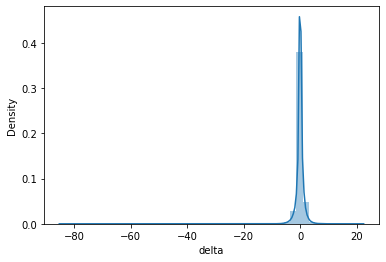

In [ ]:
sns.distplot(train_preds.delta, bins=50)

In [ ]:
result = pd.merge(test.reset_index(), test_preds.reset_index(), on='index').drop('index', axis=1)[['id', 'scalar_coupling_constant']]
result.head()

,id,scalar_coupling_constant
0,4658147,4.841054
1,4658148,197.688375
2,4658149,-1.295304
3,4658150,197.688375
4,4658151,4.841054


In [ ]:
del x_tr, x_test, y_tr, y_test, x_val, y_val

In [ ]:
# Neural Network

In [11]:
x_tr, x_test, y_tr, y_test = train_test_split(X_all, y, test_size=0.05)

In [9]:
class MolNet(torch.nn.Module):
    def __init__(self, n_hidden_neurons, m_hidden_neurons, k_hidden_neurons, j_hidden_neurons):
        super(MolNet, self).__init__()
        
        self.fc1 = torch.nn.Linear(15, n_hidden_neurons)
        self.activ1 = torch.nn.Tanh()
        self.fc2 = torch.nn.Linear(n_hidden_neurons, m_hidden_neurons)
        self.activ2 = torch.nn.Tanh()
        self.fc3 = torch.nn.Linear(m_hidden_neurons, k_hidden_neurons)
        self.activ3 = torch.nn.Tanh()
        self.fc4 = torch.nn.Linear(k_hidden_neurons, j_hidden_neurons)
        self.activ4 = torch.nn.Tanh()
        self.fc5 = torch.nn.Linear(j_hidden_neurons, 4)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.activ1(x)
        x = self.fc2(x)
        x = self.activ2(x)
        x = self.fc3(x)
        x = self.activ3(x)
        x = self.fc4(x)
        x = self.activ4(x)
        x = self.fc5(x)
        return x

In [ ]:
def loss(preds, y_true):
  return ((preds - y_true) ** 2).mean()

In [ ]:
torch.cuda.is_available()

#!nvidia-smi

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
mol_net = MolNet(100, 250, 50, 10)

In [10]:
# mol_net = torch.load(data_folder + 'MolNet_100_250_50_10.csv')

In [ ]:
mol_net = mol_net.to(device)

optimizer = torch.optim.Adam(mol_net.parameters(), lr=1.0e-3)

In [ ]:
def grad_descent(net, optimizer, x_tr, y_tr, epochs = 200, batch_size = 10000):

  train_loss_history = []
  val_accuracy_history = []
  val_loss_history = []

  step = 0

  start = time.time()
  for epoch in range(epochs):

      x_train, x_val, y_train, y_val = train_test_split(x_tr, y_tr, test_size=0.2)
      x_train = x_train.float()
      x_val = x_val.float()

      # x_val = x_val.to(device)
      # y_val = y_val.to(device)
      step += 1
      
      order = np.random.permutation(len(x_train))
      for start_index in range(0, len(x_train), batch_size):
          optimizer.zero_grad()
          
          batch_indexes = order[start_index:start_index+batch_size]
          
          X_batch = x_train[batch_indexes].to(device)
          y_batch = y_train[batch_indexes].to(device)
          
          loss_value = loss(net.forward(X_batch), y_batch)

          loss_value.backward()
          
          optimizer.step()
      if step % 10 == 0:
        train_loss_history.append(loss_value.item())

        val_preds = net.forward(x_val).data
        val_loss_history.append(loss(val_preds, y_val))
        accuracy = (val_preds - y_val).float().mean().data
        val_accuracy_history.append(accuracy)

        print('step', step)
        print(round(((time.time()-start)/60), 2), 'min')
        print('loss_value:', round(loss_value.item(), 2))
        print('val_loss:', round(val_loss_history[-1].item(), 2))
        print('val_accuracy:', round(accuracy.item(), 3))
  
  
  end = time.time()
  print(f'{epochs}, epochs done in {round((end-start)/60, 2)} min')
  return train_loss_history, val_loss_history

In [ ]:
train_loss_history, val_loss_history = grad_descent(mol_net, optimizer, x_tr, y_tr, epochs=200, batch_size=10000)

In [ ]:
torch.save(mol_net, data_folder + 'MolNet_100_250_50_10.csv')

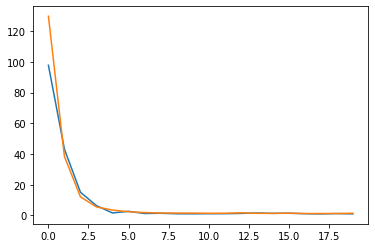

In [ ]:
plt.plot(train_loss_history)
plt.plot(val_loss_history)

In [60]:
y_sum = torch.sum(y, dim=1, keepdim=True)
y_sum

tensor([[ 84.8076],
        [-11.2569],
        [-11.2549],
        ...,
        [  1.1734],
        [  4.7620],
        [117.9341]])

In [ ]:
preds = torch.sum(mol_net.forward(X_all.float()), dim=1, keepdim=True)
preds

tensor([[ 85.4542],
        [-11.8435],
        [-11.8394],
        ...,
        [  2.0022],
        [  1.9114],
        [115.4455]], grad_fn=<SumBackward1>)

In [14]:
test_preds = torch.sum(mol_net.forward(x_test.float()), dim=1, keepdim=True).detach()
y_test_sum = torch.sum(y_test, dim=1, keepdim=True)

test_delta = (test_preds - test_sum_y)
print(f'test MAE: {mae(y_test_sum, test_preds)}')

test MAE: 1.5958216190338135


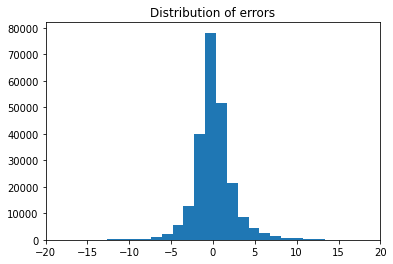

In [39]:
plt.hist(test_delta.numpy(), bins=100);
plt.xlim(-20, 20);
plt.title("Distribution of errors");

In [ ]:
torch.save(preds, data_folder + 'Mol_net_predictions.csv')

In [58]:
# preds = torch.load(data_folder + 'Mol_net_predictions.csv')

In [ ]:
delta = (preds - y_sum).data

Text(0.5, 1.0, 'SCC_true')

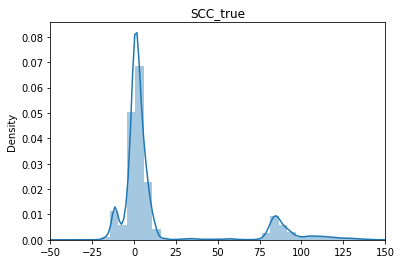

In [62]:
sns.distplot(y_sum.numpy())
plt.xlim(-50, 150)
plt.title("SCC_true")

Text(0.5, 1.0, 'SCC_predicted')

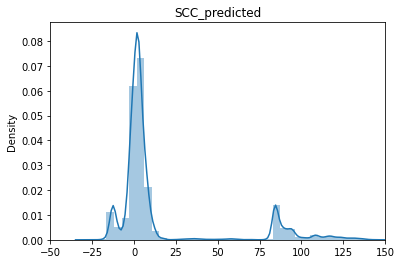

In [64]:
sns.distplot(preds.data)
plt.xlim(-50, 150)
plt.title("SCC_predicted")

In [65]:
errors = np.array(delta)
errors = pd.DataFrame(errors, columns=['delta_SCC']).reset_index()
errors = pd.merge(train.reset_index(), errors, on='index')
errors['abs_rel_delta_percent'] = abs(errors.delta_SCC / errors.scalar_coupling_constant * 100)
errors.head()

,index,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,delta_SCC,abs_rel_delta_percent
0,0,0,dsgdb9nsd_000001,1,0,1JHC,84.8076,0.646561,0.762385
1,1,1,dsgdb9nsd_000001,1,2,2JHH,-11.2570,-0.586582,5.210822
2,2,2,dsgdb9nsd_000001,1,3,2JHH,-11.2548,-0.584486,5.193215
3,3,3,dsgdb9nsd_000001,1,4,2JHH,-11.2543,-0.583565,5.185260
4,4,4,dsgdb9nsd_000001,2,0,1JHC,84.8074,0.646774,0.762639


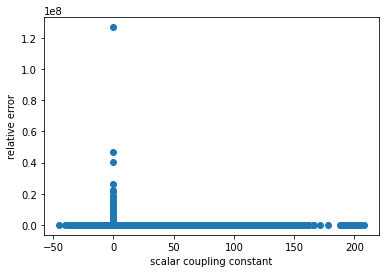

In [76]:
plt.scatter(errors.scalar_coupling_constant, errors.abs_rel_delta_percent)
plt.xlabel("scalar coupling constant");
plt.ylabel("relative error");

In [ ]:
def brutto(mol_id):
  """Brutto formula of selected molecule"""
  
  molecule = structures[['atom', 'x', 'y', 'z']].values[ssx[mol_id]:ssx[mol_id + 1]]
  tmp = dict()
  res = ''
  for atom in molecule[:, 0]:
    if atom in tmp:
      tmp[atom] += 1
    else:
      tmp[atom] = 1  

  for k, v in tmp.items():
    if v == 1:
      res += k
    else:
      res += k + str(v)
  return res

In [ ]:
# Draw molecule

!pip install --upgrade git+https://gitlab.com/ase/ase.git@master

import ase
from ase import Atoms
import ase.visualize

def draw_molecule(molecule_id):
  print(brutto(molecule_id))
  start_mol = ssx[molecule_id]
  end_mol = ssx[molecule_id+1]
  molecule = structures.iloc[start_mol:end_mol]
  
  atoms = molecule.iloc[:, 3:].values
  symbols = molecule.iloc[:, 2].values

  system = Atoms(positions=atoms, symbols=symbols)
  return ase.visualize.view(system, viewer="x3d")